In [1]:
import numpy as np

from qore import Mine, ASP, QAOA, VQE, Pseudoflow
#from qore import ASPSolver, QAOASolver, PseudoflowSolver

from qore.utils import get_bitstring_probabilities

In [2]:
qmine = Mine('mine_config.txt')

# penalty = 20.0
# qmine = Mine(np.array([[-2., 3., 1., -1.], [float('inf'), 5., 3., float('inf')]]))

# penalty = 5.0
# qmine = Mine(np.array([[-2.0, 3.0, -1.0, -2.0, -1.0], [float('inf'), 5.0, 3.0, 10.0, float('inf')], [float('inf'), float('inf'), 4.0, float('inf'), float('inf')]]))

qmine.plot_mine()

+---+--------+-------+-------+
|   |   0    |   1   |   2   |
+---+--------+-------+-------+
| 0 | -2.000 | 3.000 | 1.000 |
| 1 |  inf   | 5.000 |  inf  |
+---+--------+-------+-------+


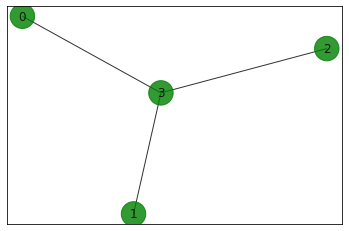

In [3]:
qmine.plot_mine_graph('g')

In [4]:
print(qmine.gen_Hamiltonian(penalty=10.))

-0.0 * IIII
+ 1.0 * IIII
- 1.0 * IIIZ
- 1.5 * IIII
+ 1.5 * IIZI
- 0.5 * IIII
+ 0.5 * IZII
- 2.5 * IIII
+ 2.5 * ZIII
+ 0.0 * IIII
+ 2.5 * IIII
+ 2.5 * IIIZ
- 2.5 * ZIII
- 2.5 * ZIIZ
+ 2.5 * IIII
+ 2.5 * IIZI
- 2.5 * ZIII
- 2.5 * ZIZI
+ 2.5 * IIII
+ 2.5 * IZII
- 2.5 * ZIII
- 2.5 * ZZII


## Pseudoflow

In [5]:
res = qmine.solve(Pseudoflow(), 10.)
print(res)

OrderedDict([   ('expected_profit', None),
                ('expected_violation', None),
                ('ground_state', None),
                ('optimal_config', '1111'),
                ('optimal_config_prob', None)])


## ASP

In [6]:
penalty = 10.0
evol_time = 20
nsteps = 40

algo = ASP(evol_time, nsteps)
res = qmine.solve(algo, penalty)
print(res)

OrderedDict([   ('expected_profit', None),
                ('expected_violation', None),
                (   'ground_state',
                    {   '0000': 0.001953125,
                        '0010': 0.001953125,
                        '0100': 0.005859375,
                        '0101': 0.0009765625,
                        '0110': 0.0634765625,
                        '0111': 0.005859375,
                        '1001': 0.0009765625,
                        '1010': 0.001953125,
                        '1011': 0.0009765625,
                        '1100': 0.00390625,
                        '1101': 0.017578125,
                        '1111': 0.89453125}),
                ('optimal_config', '1111'),
                ('optimal_config_prob', 0.89453125)])


In [7]:
# add a callback function
def analysis(circ):
    x = get_bitstring_probabilities(circ, algo.quantum_instance)
    bitstr, prob = max(x.items(), key=lambda item: item[1])
    print(f"The most probable configuration and the corresponding probability: {bitstr, prob}")

In [8]:
algo = ASP(evol_time, nsteps, callback=analysis, callback_freq=5)
res = qmine.solve(algo, penalty)
print(res)

The most probable configuration and the corresponding probability: ('0001', 0.0869140625)
The most probable configuration and the corresponding probability: ('0110', 0.1357421875)
The most probable configuration and the corresponding probability: ('1111', 0.236328125)
The most probable configuration and the corresponding probability: ('1111', 0.533203125)
The most probable configuration and the corresponding probability: ('1111', 0.861328125)
The most probable configuration and the corresponding probability: ('1111', 0.84375)
The most probable configuration and the corresponding probability: ('1111', 0.876953125)
The most probable configuration and the corresponding probability: ('1111', 0.9111328125)
OrderedDict([   ('expected_profit', None),
                ('expected_violation', None),
                (   'ground_state',
                    {   '0000': 0.0009765625,
                        '0100': 0.0068359375,
                        '0110': 0.0751953125,
                        '0

## QAOA

In [ ]:
qaoa = QAOASolver(qmine, p=3)

In [ ]:
penalty = 10.0

qaoa.solve(penalty)